In [25]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:44299'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [26]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
# input_paths.append('/work/ab0995/a270062/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/Greensplit/outdata/fesom')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

vname     = 'gmoc' # 'gmoc', 'amoc', 'aamoc', 'ipmoc', 'pmoc', 'imoc', shp.Reader(custom_shapefile_path)
# vname     = shp.Reader(os.path.join(os.path.expanduser('~/tripyview/tripyview/shapefiles/moc_basins/'), 'MY_MOC.shp'))

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl       = None
do_allcycl   = False
year         = [1979, 2019]
mon          = None
day          = None
record       = None 
box          = None
depth        = None
dlat         = 1.0   # binning resolution in deg 
do_bolus     = False
which_transf = 'dmoc' # 'srf', 'inner', 'dmoc'
do_zcoord    = True  # do zcoord. remapping 

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
# from where provide zinfo for projection to zcoord, options: 'std_dens_H'(Best), 'hydrography'(OK), 
# 'density_dMOC'(Bad), 'std_dens_Z'(Very Bad)
do_useZinfo       = 'std_dens_H'
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True   # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [27]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem, 
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:36629' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/37857/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/37857/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36629,Workers: 32
Dashboard: /user/a270042/levante-spawner-preset//proxy/37857/status,Total threads: 64
Started: 23 minutes ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:43693,Total threads: 2
Dashboard: /user/a270042/levante-spawner-preset//proxy/45081/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:35399,


In [28]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________            
# define density levels 
# !!! ATTENTION: !!!
# use here the density MOC levels that are specfic for your run. They might be different from the one im 
# using here since they might need to be customized specific to your hydrography to be able to cover the 
# whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

# original dima
std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# # my density layers 2nd try
# std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
#           32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
#           33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
#           34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
#           35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
#           35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
#           36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
#           36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
#           37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 1    , #put here the time res. of you file if not daily  
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto', 
               'ndens': len(std_dens), 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of horizontal chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.05
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    if   chunks['ndens']!= 'auto': chunk_size = chunk_size/chunks['ndens']
    chunks['elem'] = chunks['nod2'] = np.int32(np.ceil(chunk_size))
    print(' --> set elem/nod2 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 343.32Mb
 --> set elem/nod2 chunk size to 5.00% of worker mem.: 1011236


/work/ab0995/a270062/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/Greensplit/outdata/fesom Tido Test
 --> elasped time to load data: 0.74 min.
 --> data uses 4.21 Gb:



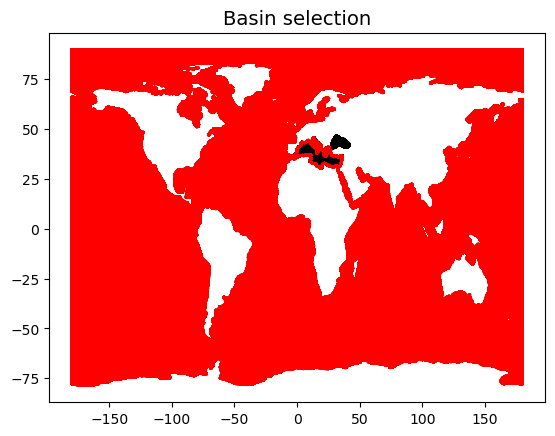

 --> rechunk: 7 -> 64
 --> elasped time to compute dmoc: 1.84 min.
 --> data uses 0.00 Gb:

 --> total elasped time: 1.85 min.


In [29]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
#___LOAD FESOM2 DATA___________________________________________________________________________________    
flag_checkb = True
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________    
    data = tpv.load_dmoc_data(mesh, datapath, std_dens, year=year, which_transf=which_transf, descript=descript,
                              do_zcoord=do_zcoord, do_useZinfo=do_useZinfo, do_bolus=do_bolus, chunks=chunks, 
                              do_load=False, do_persist=False, do_parallel=do_parallel, do_info=False, )

    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #___COMPUTE XMOC___________________________________________________________________________________
    # dmoc     = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, which_transf=which_transf, do_info=False, 
    #                          do_checkbasin=flag_checkb, exclude_meditoce=False, 
    #                          do_parallel=do_parallel, n_workers=128-parallel_nprc)
    dmoc     = tpv.calc_dmoc_dask(mesh, data, do_parallel, parallel_nprc, dlat=dlat, which_moc=vname, 
                                  which_transf=which_transf, do_info=False, do_checkbasin=flag_checkb, 
                                  do_exclude=True, #exclude mediterranean and black sea from gmoc
                                  exclude_list=list(['ocean_basins/Mediterranean_Basin.shp', [26,42,39.5,47]]) )    
    print(' --> elasped time to compute dmoc: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(dmoc.nbytes/(1024**3)))
    print('')
    flag_checkb = False  
    del(data)
    
    #__________________________________________________________________________________________________        
    # compute absolute or anomalie    
    if (ref_path != None): 
        if ii == 0: 
            dmoc_ref = dmoc.copy()
            if do_reffig: data_list.append( dmoc_ref ) 
        else:        
            data_list.append( tpv.do_anomaly(dmoc, dmoc_ref) )
    else:                                                   
        data_list.append( dmoc )
print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  ))  

--> histo: cmin, cmax =  -31.208717346191406 25.6687068939209
{'cstr': 'blue2red', 'cnum': 15, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -31.21, 'cmax': 25.67, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ffdb2c28c70>, 'clevel': array([-32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5,
       -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,
        12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  27.5]), 'clab': array([-30., -20., -10.,   0.,  10.,  20.])}


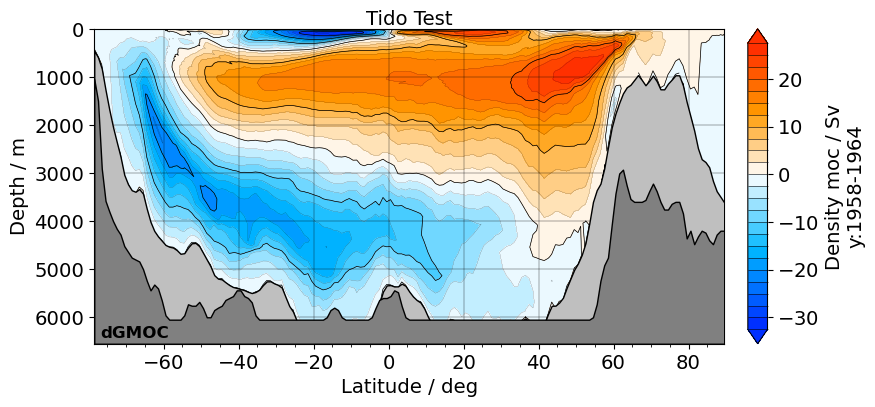

 --> elasped time to plot data: 0.01 min.


In [30]:
#___PLOT ZONMEAN TRANSECT______________________________________________________________________________
ts = clock.time()
ndat = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
stname = data_list[0][svname].attrs['short_name'].replace(' ','_').lower()
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc', stname ,slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, cinfo=cinfo0, do_rescale=do_rescale,
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(), do_bot=False, 
                                    do_save=sfpath, save_dpi=save_dpi, grid_opt=dict({'do_ysigma':True})
                                )  
print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [ ]:
if do_papermill and do_parallel and client is not None: client.shutdown()